In [1]:
import os
import sys
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import random
import monai
from os import makedirs
from os.path import join, basename
from tqdm import tqdm
from copy import deepcopy
from time import time
import numpy as np
import torch
import yaml
import cv2
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from transformers import CLIPTokenizer, CLIPTextModel
import argparse
from torch.nn.parallel import DataParallel
import json
from modules import DiscreteGroupImageCanonicalization, ESCNNEquivariantNetwork
from modules import TextPromptEncoder, MedSAMWithCanonicalization
from modules import sam_model_registry
from utils import FLanSDataset, FLanSDataset_pos_only
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
warnings.filterwarnings("ignore")

# print("All warnings are suppressed!")
seed = 0
torch.cuda.empty_cache()
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True  # To ensure deterministic behavior for certain operations
torch.backends.cudnn.benchmark = False  # Turn off optimization that may introduce randomness

### 2. Load FLanS

In [3]:
os.chdir("/home/ec2-user/SageMaker/SegmentAsYouWish/text_prompt")
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Load labels
with open("prompts/free_form_text_prompts.json", 'r') as file:
    label_dict = json.load(file)

with open("configs/test_data_paths.json", 'r') as file:
    test_data_path_lists = json.load(file)
    
with open("prompts/positional_free_form_text_prompts.json", 'r') as file:
    pos_prompt_dict = json.load(file)

with open("prompts/organ_positions.json", 'r') as file:
    pos_file_dict = json.load(file)
    
with open("prompts/organ_bounding_boxes.json", 'r') as file:
    pos_box_dict = json.load(file)
    
config_yaml = load_config("configs/train_config_main1.yaml")
checkpoint_name = "82_checkpoint_cosine_two_stage_canonTrue_augTrue_classify_headFalse_freezeimagencoderFalse_lr_prompt0.0001_lr_imgenc0.0001_lr_imgdec0.0001_lr_can0.0001_lr_class0.0001_bz2_poolingmean_gradstraight_through_canparams9_8_3_8.pth"
work_dir = config_yaml["data"]["work_dir"]
num_epochs = config_yaml["hyperparameter"]["max_epochs"]
batch_size = config_yaml["hyperparameter"]["batch_size"]
num_workers = config_yaml["hyperparameter"]["num_workers"]
medsam_checkpoint = config_yaml["model"]["medsam_checkpoint"]
data_aug = config_yaml["train"]["data_aug"]
seed = config_yaml["hyperparameter"]["seed"]
augmented_textlabel = config_yaml["train"]["textlabel_aug"]
use_canonicalization = config_yaml["train"]["use_canonicalization"]
freeze_image_encoder = config_yaml["train"]["freeze_image_encoder"]
use_classify_head = config_yaml["train"]["classify_head"]
text_pooling = config_yaml["hyperparameter"]["text_pooling"]

print("Test Datasets:", test_data_path_lists.keys())

import textwrap

def wrap_title(title, width=40):
    """Wrap text with textwrap module."""
    return "\n".join(textwrap.wrap(title, width=width))

Test Datasets: dict_keys(['FLARE22_test', 'WORD_test', 'RAOS'])


In [4]:

with torch.no_grad():
    ###### Initialize Text Prompt Encoder ###### 
    text_prompt_encoder = TextPromptEncoder(
        embed_dim=config_yaml["model"]["text_embed_dim"],
        image_embedding_size=(64, 64),
        input_image_size = (config_yaml["data"]["image_size"], config_yaml["data"]["image_size"]),
        mask_in_chans=1,
        activation=nn.GELU,
    )

    sam_model = sam_model_registry["vit_b"](checkpoint=medsam_checkpoint)
    medsam_prompt_encoder_state_dict = sam_model.prompt_encoder.state_dict()
    ## Load pretrained weights from MedSAM's prompt encoder except for the text encoder
    for keys in text_prompt_encoder.state_dict().keys():
        if keys in medsam_prompt_encoder_state_dict.keys():
            text_prompt_encoder.state_dict()[keys] = deepcopy(medsam_prompt_encoder_state_dict[keys])
        else:
            assert keys.startswith("text_encoder")

    ###### Initialize Canonicalization Network ###### 
    class CanonicalizationHyperparams:
        def __init__(self):
            self.network_type = "escnn" # group equivariant canonicalization
            self.resize_shape = config_yaml["canonicalization"]["resize_shape"] # resize shape for the canonicalization network
            self.network_hyperparams = {
                "kernel_size": config_yaml["canonicalization"]["kernel_size"], # Kernel size for the canonization network
                "hidden_dim": config_yaml["canonicalization"]["hidden_dim"],
                "out_channels": config_yaml["canonicalization"]["out_channels"], # Number of output channels for the canonization network
                "num_layers": config_yaml["canonicalization"]["num_layers"], # Number of layers in the canonization network
                "group_type": config_yaml["canonicalization"]["group_type"],#"roto-reflection", #rotation", # Type of group for the canonization network
                "group_order": config_yaml["canonicalization"]["group_order"], # Number of rotations for the canonization network 
            }
            self.beta = config_yaml["canonicalization"]["beta"]
            self.input_crop_ratio = config_yaml["canonicalization"]["input_crop_ratio"]
            self.gradient_trick = config_yaml["canonicalization"]["gradient_trick"] #"gumbel_softmax" / "straight_through"
    canonicalization_hyperparams = CanonicalizationHyperparams()

    # initialize the can network: 
    image_shape = (config_yaml["data"]["inp_channels"], config_yaml["data"]["image_size"], config_yaml["data"]["image_size"])
    canonicalization_def = ESCNNEquivariantNetwork(
        inp_channels = config_yaml["data"]["inp_channels"], 
        **canonicalization_hyperparams.network_hyperparams
    )#.to(device)
    canonicalization_network = DiscreteGroupImageCanonicalization(canonicalization_def, canonicalization_hyperparams, image_shape)#.to(device)



### Antonamy-Informed Prompts

In [6]:
with torch.no_grad():
    ###### Initialize the Main Model ###### 
    # need to adjsut the freeze option here: # todo
    flans_model = MedSAMWithCanonicalization(
        image_encoder=sam_model.image_encoder,
        mask_decoder=deepcopy(sam_model.mask_decoder),
        prompt_encoder=text_prompt_encoder,
        canonicalization_network = canonicalization_network, 
        use_canonicalization = use_canonicalization,
        use_classify_head = use_classify_head,
        freeze_image_encoder=freeze_image_encoder # False
    ).to(device)

    checkpoint = torch.load("results/foundation_model/" + checkpoint_name)
    flans_model.load_state_dict(checkpoint["model"], strict = False)
    flans_model.use_canonicalization = False

In [233]:
test_dataset = FLanSDataset(data_path_lists = {'FLARE22_test': 'data/touse/FLARE22/npy/CT_Abd_test'}, label_dict = label_dict, data_aug = False)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True, num_workers=8, pin_memory=False)
for num, batch in enumerate(test_loader):
    image, gt2D, tokens, text = batch["image"].to(device), batch["gt2D"].to(device), batch["token"].to(device),  batch["text"]
    break

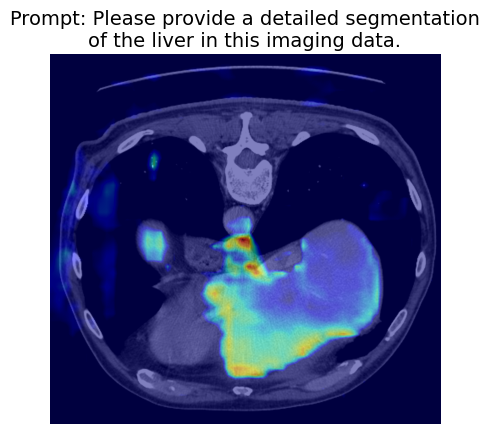

In [298]:
idx = 0
with torch.no_grad():
    text_embeddings, dense_embeddings = flans_model.prompt_encoder(
                points=None,
                boxes=None,
                masks=None,
                tokens=tokens[idx:idx+1],
            )

    image_embedding = flans_model.image_encoder(image[idx:idx+1]) 
    attn_map = np.abs(torch.einsum("bld, bdhw -> blhw", text_embeddings, image_embedding).cpu().data.numpy())
    attn_map -= attn_map.min()
    attn_map /= attn_map.max()
    
attn_map_1024 = np.clip(cv2.resize(attn_map[0][3], (1024, 1024), interpolation=cv2.INTER_LINEAR), a_min=0.2, a_max=1)
image_np = image[idx].permute(1,2,0).cpu().data.numpy()
alpha = 0.5
cmap = 'jet' # viridis inferno hot RdBu coolwarm jet plasma
wrapped_title = wrap_title("Prompt: " + text[0][idx], width=48)
plt.title(wrapped_title, fontsize = 14)
plt.imshow(image_np[50:-100, 50:-50], cmap='gray')
plt.imshow(attn_map_1024[50:-100, 50:-50], cmap=cmap, alpha=alpha)
plt.axis('off')
# plt.savefig('attn_informed2_'+str(idx)+'.png', dpi=200, bbox_inches='tight')  # Saving

### Antonamy-Agnositic Prompts

In [316]:
test_dataset = FLanSDataset_pos_only(data_path_lists = test_data_path_lists,
                                     label_dict = label_dict, 
                                      pos_file_dict = pos_file_dict, 
                                      pos_prompt_dict = pos_prompt_dict,
                                      pos_box_dict = pos_box_dict)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

for num, batch in enumerate(test_loader):
    image, gt2D, tokens, text = batch["image"].to(device), batch["gt2D"].to(device), batch["token"].to(device),  batch["text"]
    break

(-0.5, 1023.5, 1023.5, -0.5)

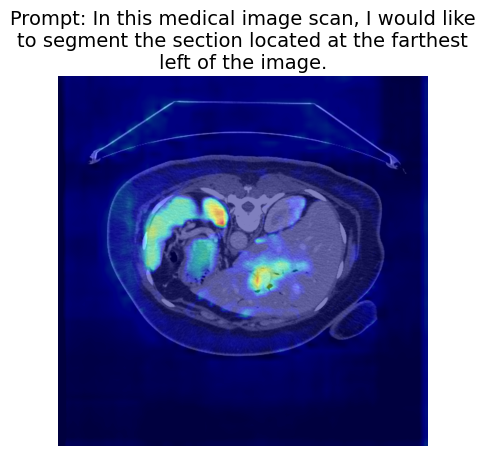

In [339]:
idx = 8
with torch.no_grad():
    text_embeddings, dense_embeddings = flans_model.prompt_encoder(
                points=None,
                boxes=None,
                masks=None,
                tokens=tokens[idx:idx+1],
            )

    image_embedding = flans_model.image_encoder(image[idx:idx+1]) 
    attn_map = np.abs(torch.einsum("bld, bdhw -> blhw", text_embeddings, image_embedding).cpu().data.numpy())
    attn_map -= attn_map.min()
    attn_map /= attn_map.max()
    
attn_map_1024 = np.clip(cv2.resize(attn_map[0][1], (1024, 1024), interpolation=cv2.INTER_LINEAR), a_min=0.2, a_max=1)
image_np = image[idx].permute(1,2,0).cpu().data.numpy()
alpha = 0.5
cmap = 'jet' # viridis inferno hot RdBu coolwarm jet plasma
wrapped_title = wrap_title("Prompt: " + text[0][idx], width=48)
plt.title(wrapped_title, fontsize = 14)
plt.imshow(image_np, cmap='gray')
plt.imshow(attn_map_1024, cmap=cmap, alpha=alpha)
plt.axis('off')
# plt.savefig('attn_shape2_'+str(idx)+'.png', dpi=200, bbox_inches='tight')  # Saving

## Customized Input

In [223]:
test_dataset = FLanSDataset(data_path_lists = test_data_path_lists, label_dict = label_dict, data_aug = False)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle=True, num_workers=8, pin_memory=False)
for num, batch in enumerate(test_loader):
    image, gt2D, tokens, text = batch["image"].to(device), batch["gt2D"].to(device), batch["token"].to(device),  batch["text"]
    break

In [284]:
cus_text = "Segment the organ above the left kidney"#"In the lower left lobe of the liver is a hyperintensity, please segment it for me"# "Segment the organ above the left kidney" #Predict the liver, but without the hepatic vessels
cus_token = test_dataset.tokenize_text(cus_text)

In [314]:
idx = 14
with torch.no_grad():
    flans_pred = flans_model(image[idx:idx+1], cus_token.unsqueeze(0).to(image.device))[0]
    flans_pred = (torch.sigmoid(flans_pred) > 0.5).float().cpu().data.numpy()[0,0]
    flans_pred = cv2.resize(flans_pred, (1024, 1024), interpolation=cv2.INTER_LINEAR)
    image_np = image[idx].permute(1,2,0).cpu().data.numpy()

(-0.5, 1023.5, 1023.5, -0.5)

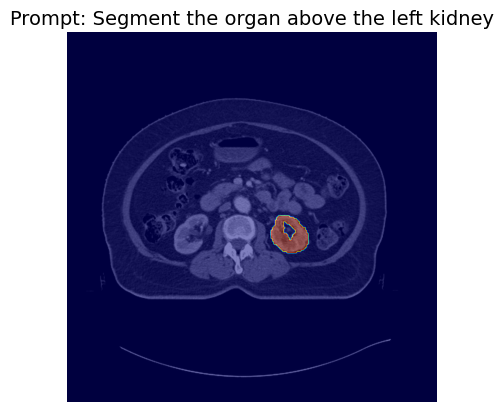

In [315]:
wrapped_title = wrap_title("Prompt: " + cus_text, width=48)
plt.title(wrapped_title, fontsize = 14)
plt.imshow(image_np)
plt.imshow(flans_pred, cmap=cmap, alpha=alpha)  
# plt.set_title('FLanS', size=30, fontdict={'family': 'serif', 'weight': 'bold'})
plt.axis('off')
# plt.savefig('reviewer2'+str(idx)+'.png', dpi=200, bbox_inches='tight')  # Saving